# 1. Introduction

    What is the input data?
    What type of problem? Multiclass singlelabel classification
    Terminology

- the notebook has been run many times, I will refer to results in a more general range ie. the baseline model first time had 37% accuracy, the second run has 41% accuracy
- I will try to talk generally about the results and my reasoning as to why I chose or went certain directions
- justification on things backed up by research, and possibly unseen model testing to keep the notebook more concise

### Aims and Objectives

BE SPECIFIC
- 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import tensorflow as tf
import keras
from keras import models, layers, regularizers, optimizers

from keras.datasets import cifar10

# empty array to store future model information
model_summary = []

# load data from library
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'{X_train.shape[0]} train samples')
print(f'{X_test.shape[0]} test samples')

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [3]:
# examine data in first sample with label
print(f'first sample:\n{X_train[0][0][:5]}\n...\n')
print(f'first label: {y_train[0]}')

first sample:
[[59 62 63]
 [43 46 45]
 [50 48 43]
 [68 54 42]
 [98 73 52]]
...

first label: [6]


# 2. Choosing a measure of success

    Accuracy?
    Precision and recall?


Thoughts and approaches after first examination of data

In [305]:
# mapping of label to names
target_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"}

classes = np.arange(0, 10, 1)
class_names = [target_names[name] for name in classes]

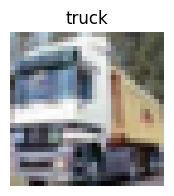

In [5]:
# plot single image sample from data set
def plot_sample(sample=X_train[0], label=6):
    data = sample

    # set plot parameters
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.title(target_names[label])

    # Use imshow to plot pixels
    plt.imshow(data)

    # Display the plot
    plt.show()


plot_sample(X_train[1], y_train[1][0])

12 sample plot


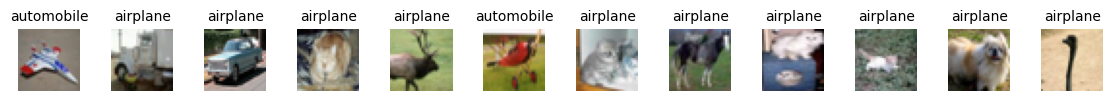

In [99]:
# plot multiple images from cifar10 dataset as subplots
def plot_multi_sample(samples=X_train[0:8], labels=[6, 9, 9, 4, 1, 1, 2, 7],
                      pred_labels=None, name='sample plot'):
    length = len(samples)

    # create horizontal figure with subplots
    fig, axes = plt.subplots(1, length, figsize=(14, 8))
    axes = axes.flatten()

    # create subplot for each image data
    for i in range(length):
        data = samples[i]
        label = labels[i]

        # plot parameters
        plt.subplot(1, length, i+1)
        plt.axis('off')

        if pred_labels is not None:
            plt.title(f'True: {target_names[labels[i]]}\nPred: {target_names[pred_labels[i]]}',
                      fontsize=10)
        else:
            plt.title(target_names[labels[i]],
                      fontsize=10)
        plt.subplots_adjust(wspace=0.5)
        plt.imshow(samples[i])

    # display sample count and show plot
    print(f'{length} {name}')
    plt.show()


plot_multi_sample(X_train[30:42], [y[0] for y in y_train[30:42]])

# 3. Evaluation Protocol

    Hold-out? Our dataset is sufficiently big and well balanced
    K-fold?


In [7]:
from sklearn.model_selection import train_test_split

# split into validation data and partial training data
# stratify=y_train to ensure even porportion of split labels
x_partial, x_val, y_partial, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=2, stratify=y_train)

print(x_partial.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')


40000 train samples
10000 validation samples
10000 test samples


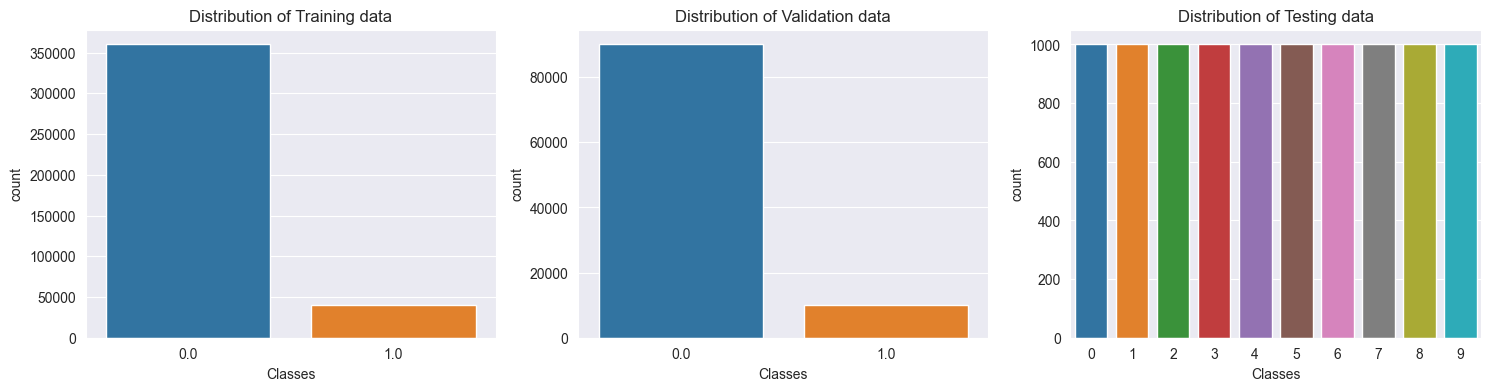

In [274]:
# show distribution of samples by countplot
sns.set_style("darkgrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
# plot for training set
sns.countplot(x=y_partial.ravel(), ax=axes[0])
axes[0].set_title('Distribution of Training data')
axes[0].set_xlabel('Classes')

# plot for validation set
sns.countplot(x=y_val.ravel(), ax=axes[1])
axes[1].set_title('Distribution of Validation data')
axes[1].set_xlabel('Classes')

# plot for testing set
sns.countplot(x=y_test.ravel(), ax=axes[2])
axes[2].set_title('Distribution of Testing data')
axes[2].set_xlabel('Classes')
plt.show()


# 4. Preprocessing Data

    Manipulate into tensors
    Normalize values [0, 1]
    Data visualization is not necessary


In [9]:
# from tensorflow.keras.utils import to_categorical

"""
preprocess data, normalize range to [0,1]
"""
def prep_normalize(data):
    data = data.astype('float32') / 255
    return data


"""
one-hot encode integer label data to categorical
"""
def prep_encoder(data, classes=10):
    data = tf.keras.utils.to_categorical(
        data, num_classes=classes, dtype='float32'
    )
    return data

In [10]:
# normalize samples
x_partial = prep_normalize(x_partial)
x_val = prep_normalize(x_val)
x_test = prep_normalize(X_test)

# one-hot encode labels
y_partial = prep_encoder(y_partial)
y_val = prep_encoder(y_val)

y_test = y_test.ravel()

print(x_partial)
print(y_partial)

[[[[0.44705883 0.72156864 0.8509804 ]
   [0.4392157  0.70980394 0.8392157 ]
   [0.44313726 0.70980394 0.8392157 ]
   ...
   [0.4392157  0.7019608  0.84313726]
   [0.43529412 0.7019608  0.84313726]
   [0.43529412 0.7058824  0.84313726]]

  [[0.44705883 0.72156864 0.84705883]
   [0.4392157  0.70980394 0.8352941 ]
   [0.44313726 0.70980394 0.8352941 ]
   ...
   [0.43137255 0.69803923 0.83137256]
   [0.43137255 0.7019608  0.83137256]
   [0.43529412 0.70980394 0.8392157 ]]

  [[0.45490196 0.73333335 0.84705883]
   [0.44313726 0.7176471  0.827451  ]
   [0.44313726 0.7137255  0.827451  ]
   ...
   [0.43137255 0.7019608  0.83137256]
   [0.43137255 0.7019608  0.83137256]
   [0.43137255 0.70980394 0.83137256]]

  ...

  [[0.8784314  0.78039217 0.6039216 ]
   [0.83137256 0.7372549  0.5647059 ]
   [0.8235294  0.7294118  0.5568628 ]
   ...
   [0.8666667  0.74509805 0.5372549 ]
   [0.8392157  0.7176471  0.5058824 ]
   [0.84705883 0.73333335 0.52156866]]

  [[0.8392157  0.7411765  0.5686275 ]
   [0.8

In [11]:
# helper functions

"""
function to plot model history
"""
def plot_history(history, name='Model'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # plot training & valid loss
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title(f'{name} Loss History')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Training', 'Validation'])
    axes[0].grid(linestyle='dotted')
    # axes[0].legend(['Training', 'Validation'], loc='upper left')

    # plot training & valid accuracy
    axes[1].plot(history.history['accuracy'])
    axes[1].plot(history.history['val_accuracy'])
    axes[1].set_title(f'{name} Accuracy History')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Training', 'Validation'])
    axes[1].grid(linestyle='dotted')
    plt.show()


# loss and accuracy with testing set
def evaluate_model(model):
    loss, acc = model.evaluate(x_test, prep_encoder(y_test), verbose=1)
    print(f'Test loss: {loss}')
    print(f'Test accu: {acc}')
    return loss, acc


# optimal epoch
def optimal_epoch(history):
    min_loss = np.argmin(history.history['val_loss'])
    max_accu = np.argmax(history.history["val_accuracy"])
    print(f'Min loss at epoch: {min_loss}')
    print(f'Max accu at epoch: {max_accu}')
    return min_loss, max_accu


In [12]:
# more helper functions

"""
moving average
adapted from #answer-26337730 [2]
"""
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


"""
plot multiple history graphs for comparing rate differences
"""
def plot_history_comparison(histories, legend_names, title, lim=None, dotted=None):
    SMOOTH_N = 10  # number of last datapoints to average

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # plot training & valid loss for multiple models
    for i, history in enumerate(histories):
        # truncate and smooth data before plotting
        data = smooth(history.history['val_loss'], SMOOTH_N)
        if lim:
            data = data[:lim]
        if dotted and i+1 in dotted:
            axes[0].plot(data, linestyle='dotted')
        else:
            axes[0].plot(data)
    axes[0].set_title(f'{title} Validation Loss Comparison')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(legend_names)
    axes[0].grid(linestyle='dotted')

    # plot training & valid accuracy
    for i, history in enumerate(histories):
        # truncade and smooth data before plotting
        data = smooth(history.history['val_accuracy'], SMOOTH_N)
        if lim:
            data = data[:lim]
        if dotted and i+1 in dotted:
            axes[1].plot(data, linestyle='dotted')
        else:
            axes[1].plot(data)
    axes[1].set_title(f'{title} Validation Accuracy Comparison')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(legend_names)
    axes[1].grid(linestyle='dotted')
    plt.show()

# 5. Developing a Baseline Model

    Aim for statistical power
    State the common-sense baseline: 10%
    Last layer? softmax
    Loss Function? crossentropy
    Optimizer? RMSProp


- multiclass single label dataset, use crossentropy for loss
- this is classification, so we'll use accuracy as the metric
- for now use rmsprop as the optimizer

- image classification, for the sake of baseline comparisons, we'll start with a dense layer and compare with convolution layers later
- it will be as large as the input shape


In [13]:
"""
baseline two layer dense model width:32
"""
def dense_baseline_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',
              input_shape=X_train[0].shape))
    model.add(layers.Flatten())  # flatten dimensions before output
    model.add(layers.Dense(10, activation='softmax'))

    # hyperparameters
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


base_model = dense_baseline_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32, 32, 32)        128       
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                327690    
                                                                 
Total params: 327,818
Trainable params: 327,818
Non-trainable params: 0
_________________________________________________________________


In [14]:
N_EPOCHS = 100
BATCH_SIZE = 32


base_history = base_model.fit(x_partial, y_partial,
                    validation_data=(x_val, y_val),
                    epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.6975 - accuracy: 0.4115 - val_loss: 1.5778 - val_accuracy: 0.4558
Epoch 2/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.5247 - accuracy: 0.4790 - val_loss: 1.5771 - val_accuracy: 0.4597
Epoch 3/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4744 - accuracy: 0.4967 - val_loss: 1.5504 - val_accuracy: 0.4684
Epoch 4/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4400 - accuracy: 0.5122 - val_loss: 1.5598 - val_accuracy: 0.4718
Epoch 5/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4146 - accuracy: 0.5204 - val_loss: 1.5446 - val_accuracy: 0.4866
Epoch 6/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3940 - accuracy: 0.5298 - val_loss: 1.5421 - val_accuracy: 0.4773
Epoch 7/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3774 - accuracy: 0.5366 - val_loss: 1.5589 - val_ac

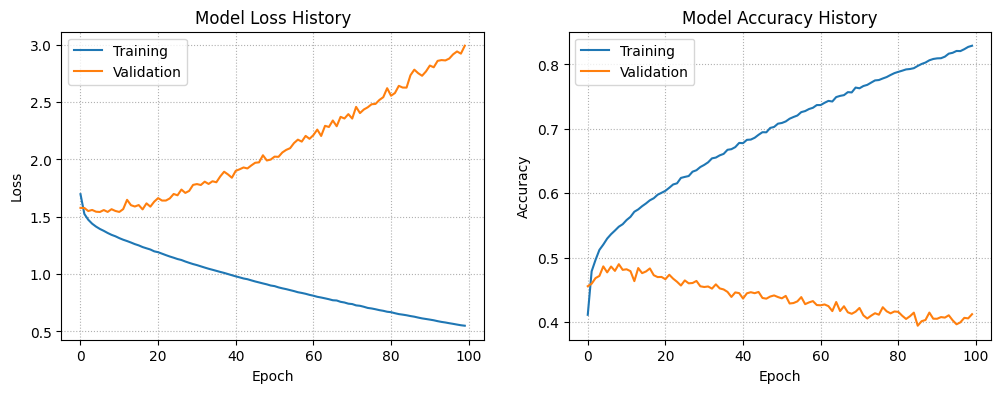

In [15]:
plot_history(base_history, 'base_model')


In [16]:
# loss and accuracy with testing set
loss_test, accu_test = evaluate_model(base_model)

# optimal epoch
loss_epoch, accu_epoch = optimal_epoch(base_history)
lowest_loss = base_history.history['val_loss'][loss_epoch]

# store results
model_summary.append(['base_model', N_EPOCHS, BATCH_SIZE, 0, 32, base_model.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 2s 5ms/step - loss: 2.8847 - accuracy: 0.4101
Test loss: 2.8846943378448486
Test accu: 0.4101000130176544
Min loss at epoch: 5
Max accu at epoch: 8


Number of correct predictions: 4101/10000
Prediction accuracy: 0.4101
10 sample plot


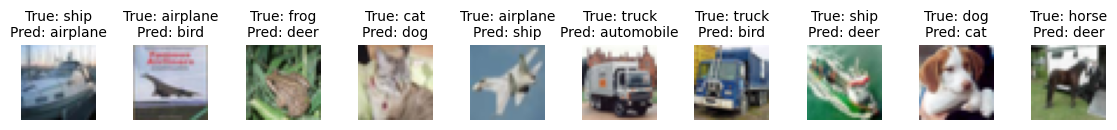

In [17]:
# use trained model to predict testing data, same as model.evaluate()
y_pred = base_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

# get index count of false predictions
errors = np.sum(y_pred != y_test)
errors_index = np.where(y_pred != y_test)[0]
test_samples = len(y_pred)

print(f'Number of correct predictions: {test_samples-errors}/{test_samples}')
print(f'Prediction accuracy: {1-errors/test_samples}')

# plot incorrect preditions, true vs predicted labels
plot_multi_sample(X_test[errors_index][:10],
                  y_test[errors_index][:10].ravel(),
                  y_pred[errors_index][:10])

### Observations & Thoughts on Baseline Model
- The baseline model overfits almost immediately
- Validation loss is very high and does not decrease from training
- Validation accuracy is very low and barely increases from training

The baseline model achieves an accuracy of ~40% means it does better than a random classifier, however high loss and low accuracy means the model is a poor predictor of unseen data and fails to generalize. This is as expected from a shallow model lacking depth, complexity, and consideration from the data set. For our purposes, there are many improvements left to make.

# 6. Developing a Convolutional Model

    From statistical power to sufficient power
    Increase model capacity, +layers, layersize
    Monitor overfitting and validation loss and other metrics
    Demonstrate graphically and in text overfitting


- a common convolutional architecture to increase depth is grouping 'blocks' of two conv2d and one maxpooling
- it removes the variance filter size, using only 3x3 stride 2
- depth of each sequential block doubles
- first introduced in vgg16


In [18]:
"""
two block model following vgg16
"""


def conv2d_model(blocks=1, optimizer='rmsprop', layer_size=1, padding='valid'):
    model = models.Sequential()

    # block 1
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
                            activation='relu',
                            padding=padding,
                            input_shape=X_train[0].shape))
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
              activation='relu', padding=padding))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # block 2
    if blocks > 1:
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # block 3
    if blocks > 2:
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # head output
    model.add(layers.Flatten())
    model.add(layers.Dense(64 * np.power(2, blocks-1) * layer_size))
    model.add(layers.Dense(10, activation='softmax'))

    # hyperparameters
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [19]:
# model 'a' with one convolutional block
model_a = conv2d_model(blocks=1)
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                401472    
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                      

In [20]:
N_EPOCHS = 100
BATCH_SIZE = 256


history_a = model_a.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 4s 11ms/step - loss: 1.6280 - accuracy: 0.4268 - val_loss: 1.4209 - val_accuracy: 0.4821
Epoch 2/100
313/313 [==============================] - 3s 10ms/step - loss: 1.2075 - accuracy: 0.5790 - val_loss: 1.1113 - val_accuracy: 0.6125
Epoch 3/100
313/313 [==============================] - 3s 10ms/step - loss: 1.0546 - accuracy: 0.6353 - val_loss: 1.2093 - val_accuracy: 0.5957
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.9664 - accuracy: 0.6639 - val_loss: 1.0739 - val_accuracy: 0.6363
Epoch 5/100
313/313 [==============================] - 3s 10ms/step - loss: 0.8994 - accuracy: 0.6870 - val_loss: 1.0732 - val_accuracy: 0.6370
Epoch 6/100
313/313 [==============================] - 3s 10ms/step - loss: 0.8448 - accuracy: 0.7087 - val_loss: 1.0262 - val_accuracy: 0.6511
Epoch 7/100
313/313 [==============================] - 3s 10ms/step - loss: 0.7976 - accuracy: 0.7219 - val_loss: 1.0757 - val_accuracy:

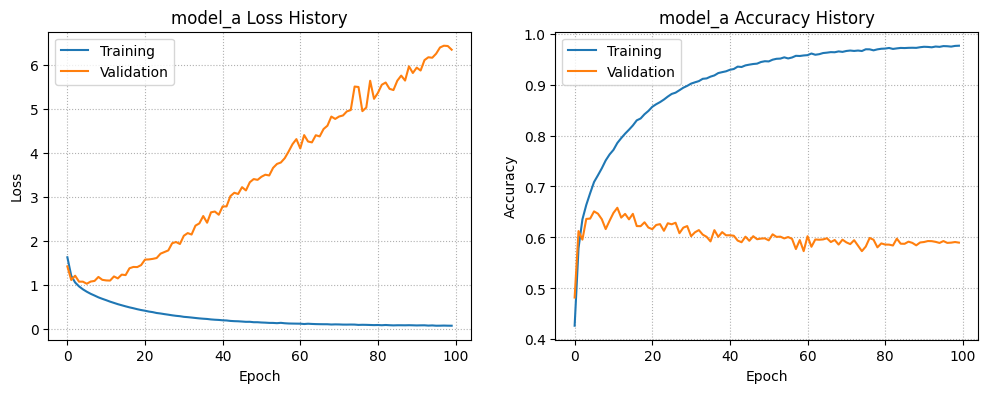

In [21]:
plot_history(history_a, 'model_a')

In [22]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_a)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_a)
lowest_loss = history_a.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_a', N_EPOCHS, BATCH_SIZE, 1, 32, model_a.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 1s 4ms/step - loss: 6.3749 - accuracy: 0.5876
Test loss: 6.374909400939941
Test accu: 0.58760005235672
Min loss at epoch: 5
Max accu at epoch: 11


In [23]:
# model 'b' with two convolutional block depth
model_b = conv2d_model(blocks=2)
model_b.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

In [24]:
N_EPOCHS = 100
BATCH_SIZE = 256


history_b = model_b.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 5s 13ms/step - loss: 1.7480 - accuracy: 0.3683 - val_loss: 1.5372 - val_accuracy: 0.4514
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 1.3519 - accuracy: 0.5225 - val_loss: 1.1728 - val_accuracy: 0.5872
Epoch 3/100
313/313 [==============================] - 4s 12ms/step - loss: 1.1359 - accuracy: 0.6041 - val_loss: 1.4828 - val_accuracy: 0.4982
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 0.9996 - accuracy: 0.6528 - val_loss: 0.9514 - val_accuracy: 0.6706
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 0.8990 - accuracy: 0.6886 - val_loss: 0.9561 - val_accuracy: 0.6784
Epoch 6/100
313/313 [==============================] - 4s 12ms/step - loss: 0.8150 - accuracy: 0.7183 - val_loss: 0.8685 - val_accuracy: 0.6996
Epoch 7/100
313/313 [==============================] - 4s 12ms/step - loss: 0.7544 - accuracy: 0.7388 - val_loss: 0.8688 - val_accuracy:

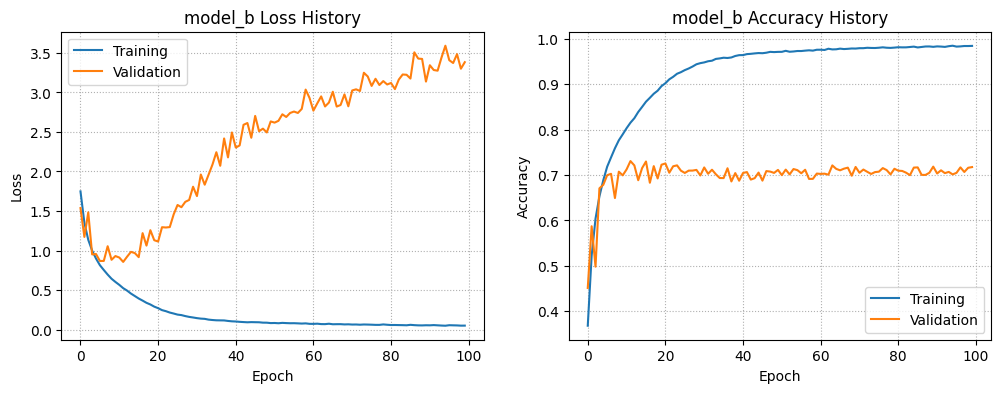

In [25]:
plot_history(history_b, 'model_b')

In [26]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_b)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_b)
lowest_loss = history_b.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_b', N_EPOCHS, BATCH_SIZE, 2, 32, model_b.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 1s 5ms/step - loss: 3.3984 - accuracy: 0.7131
Test loss: 3.398442268371582
Test accu: 0.713100016117096
Min loss at epoch: 11
Max accu at epoch: 11


In [27]:
# model 'c' with doubled layer sizes
model_c = conv2d_model(blocks=2, layer_size=2)
model_c.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                  

In [28]:
N_EPOCHS = 100
BATCH_SIZE = 256


history_c = model_c.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 7s 20ms/step - loss: 1.8310 - accuracy: 0.3435 - val_loss: 1.3950 - val_accuracy: 0.4973
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 1.2857 - accuracy: 0.5481 - val_loss: 1.1146 - val_accuracy: 0.6174
Epoch 3/100
313/313 [==============================] - 6s 19ms/step - loss: 1.0021 - accuracy: 0.6513 - val_loss: 1.0013 - val_accuracy: 0.6554
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 0.8476 - accuracy: 0.7070 - val_loss: 0.9835 - val_accuracy: 0.6715
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 0.7284 - accuracy: 0.7479 - val_loss: 0.8336 - val_accuracy: 0.7114
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6363 - accuracy: 0.7805 - val_loss: 0.7968 - val_accuracy: 0.7338
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5572 - accuracy: 0.8061 - val_loss: 1.1706 - val_accuracy:

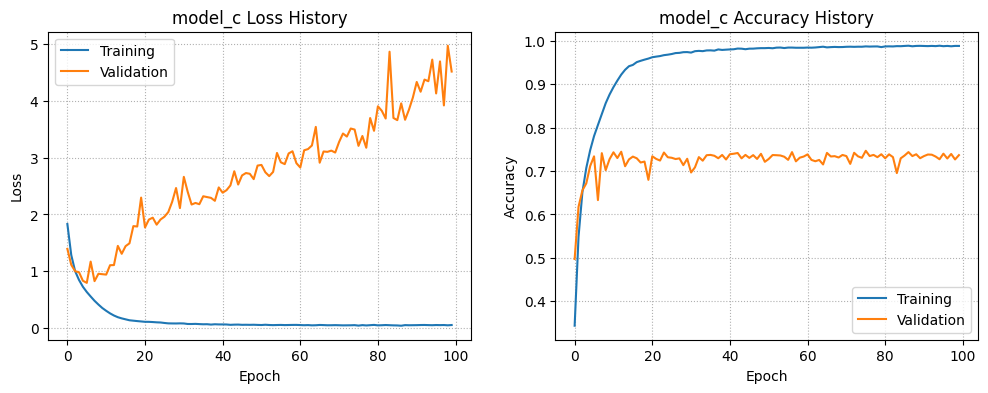

In [29]:
plot_history(history_c, 'model_c')

In [30]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_c)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_c)
lowest_loss = history_c.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_c', N_EPOCHS, BATCH_SIZE, 2, 64, model_c.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 1s 5ms/step - loss: 4.4443 - accuracy: 0.7358
Test loss: 4.444281101226807
Test accu: 0.73580002784729
Min loss at epoch: 5
Max accu at epoch: 75


## 6.1 Adding extra padding to the kernel

- bit of a hack to reduce the decreasing rate of image dimension over network depth
- native image sample resolution is small
- without padding of 0's will hit negative dimensions in block 3


In [31]:
# 3 block model test
model_d = conv2d_model(blocks=3, padding='same')
model_d.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [32]:
N_EPOCHS = 100
BATCH_SIZE = 256


history_d = model_d.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 7s 17ms/step - loss: 1.9330 - accuracy: 0.2988 - val_loss: 1.6290 - val_accuracy: 0.4110
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 1.3556 - accuracy: 0.5128 - val_loss: 1.3699 - val_accuracy: 0.5080
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 1.0729 - accuracy: 0.6199 - val_loss: 1.1387 - val_accuracy: 0.5872
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 0.8872 - accuracy: 0.6885 - val_loss: 0.8395 - val_accuracy: 0.7117
Epoch 5/100
313/313 [==============================] - 5s 16ms/step - loss: 0.7527 - accuracy: 0.7365 - val_loss: 0.8620 - val_accuracy: 0.7018
Epoch 6/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6297 - accuracy: 0.7811 - val_loss: 0.8464 - val_accuracy: 0.7115
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5345 - accuracy: 0.8130 - val_loss: 0.8703 - val_accuracy:

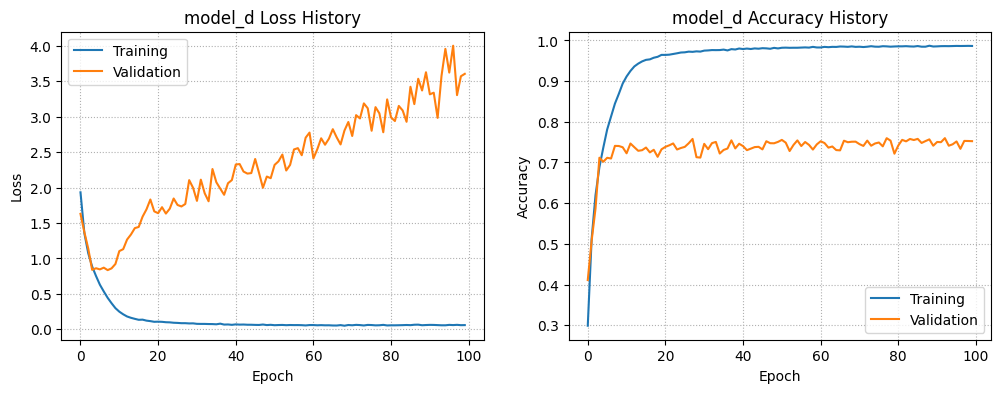

In [33]:
plot_history(history_d, 'model_d')

In [34]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_d)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_d)
lowest_loss = history_d.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_d', N_EPOCHS, BATCH_SIZE, 3, 32, model_d.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 1s 5ms/step - loss: 3.7535 - accuracy: 0.7444
Test loss: 3.7534518241882324
Test accu: 0.7444000244140625
Min loss at epoch: 7
Max accu at epoch: 92


In [35]:
# model 'e' with doubled layer sizes
model_e = conv2d_model(blocks=3, layer_size=2, padding='same')

model_e.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                  

In [36]:
N_EPOCHS = 100
BATCH_SIZE = 256


history_e = model_e.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 12s 34ms/step - loss: 2.1137 - accuracy: 0.2530 - val_loss: 1.8543 - val_accuracy: 0.3479
Epoch 2/100
313/313 [==============================] - 10s 33ms/step - loss: 1.4137 - accuracy: 0.4919 - val_loss: 1.3430 - val_accuracy: 0.5165
Epoch 3/100
313/313 [==============================] - 10s 33ms/step - loss: 1.0520 - accuracy: 0.6301 - val_loss: 1.0309 - val_accuracy: 0.6345
Epoch 4/100
313/313 [==============================] - 10s 33ms/step - loss: 0.8180 - accuracy: 0.7149 - val_loss: 0.9846 - val_accuracy: 0.6845
Epoch 5/100
313/313 [==============================] - 10s 33ms/step - loss: 0.6553 - accuracy: 0.7736 - val_loss: 0.9870 - val_accuracy: 0.6786
Epoch 6/100
313/313 [==============================] - 10s 33ms/step - loss: 0.5248 - accuracy: 0.8172 - val_loss: 0.8590 - val_accuracy: 0.7318
Epoch 7/100
313/313 [==============================] - 10s 33ms/step - loss: 0.4117 - accuracy: 0.8558 - val_loss: 0.8446 - val_ac

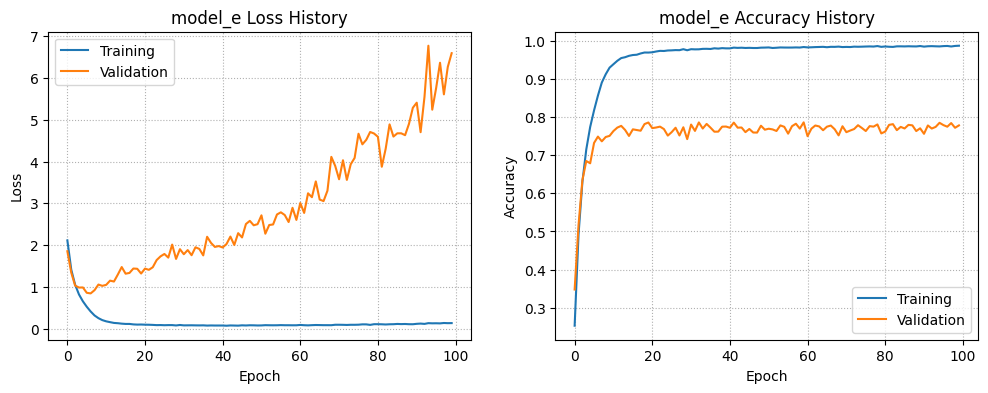

In [37]:
plot_history(history_e, 'model_e')

In [38]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_e)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_e)
lowest_loss = history_e.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_e', N_EPOCHS, BATCH_SIZE, 3, 64, model_e.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 2s 6ms/step - loss: 6.8549 - accuracy: 0.7720
Test loss: 6.854916095733643
Test accu: 0.7720000147819519
Min loss at epoch: 6
Max accu at epoch: 59


## 6.2 Comparing Different Layer Sizes

- curves get quite noisy, will use a moving average over last 10 points to smooth line
-


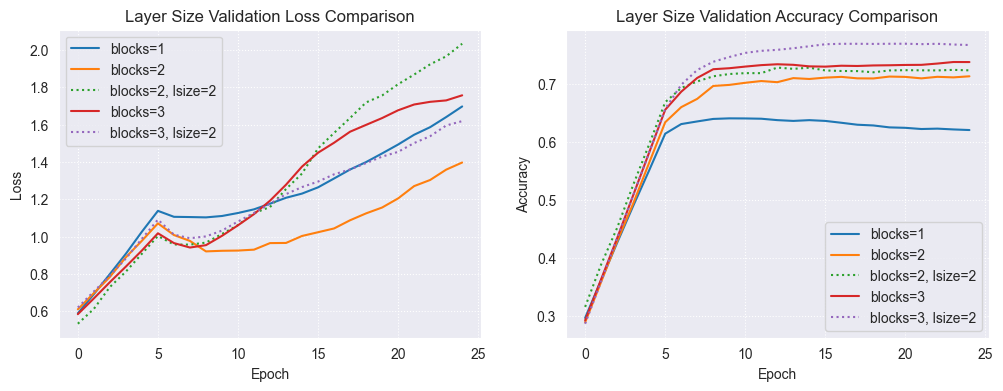

In [362]:
# plot histories of models tested so far
histories = [history_a, history_b, history_c, history_d, history_e]
params = ['blocks=1', 'blocks=2', 'blocks=2, lsize=2',
          'blocks=3', 'blocks=3, lsize=2']

plot_history_comparison(histories=histories,
                        legend_names=params,
                        title='Layer Size',
                        lim=25,
                        dotted=[3, 5])

### Observations & Thoughts on Layer Size
- Increasing layer size significantly boosted the top accuracy
- Doubling the layer size did not have a noticable impact on loss versus their counterpart
- model_b using `blocks=2` (with the least amount of parameters) has the lowest overall loss 
- model_d using `blocks=3` has the lowest initial loss before epoch ~10


Doubling layer size (`layer_size=2`) shows signs of overfitting. Increasing units per layer increases overall parameters within the model, as a result the larger model learns the training set faster over the same epochs. This is also apparent when comparing models `blocks=2` and `blocks=3`, but is less pronounced, as a larger depth learns the set better compared to a larger width. 

Adding convolutional layers was a substantial increase in performance from the baseline model. The layered depth can justify vgg16's 'block' architecture as a great approach to building better CNNs.

# 7. Regularizing and Tuning Hyperparameters

    Dropout layers
    Different Architectures
    L1 and L2 Regularization
     Demonstrate graphically regularization and taming overfitting


- use personal intuition and informed guesswork instead of a grid/random search technique to find optimal hyperparameters
- and observing loss curves to estimate the direction to go towards
- each hyperparameter can be an exploratory notebook on their own
- limit testing to 3 models, keep the notebook concise


In [40]:
"""
three block model following vgg16
"""
def conv2d_with_reg(blocks=1, dropout=None, grad_dropout=False,
                    optimizer='rmsprop', regularizer=None, layer_size=1):
    model = models.Sequential()

    # block 1
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizer,
                            input_shape=X_train[0].shape))
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(layers.Dropout(dropout))

    # block 2
    if blocks > 1:
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                                activation='relu',
                                padding='same',
                                kernel_regularizer=regularizer))
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                                activation='relu',
                                padding='same',
                                kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if dropout:
            if grad_dropout:
                model.add(layers.Dropout(dropout * 1.2))
            else:
                model.add(layers.Dropout(dropout))

    # block 3
    if blocks > 2:
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                                activation='relu',
                                padding='same',
                                kernel_regularizer=regularizer))
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                                activation='relu',
                                padding='same',
                                kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if dropout:
            if grad_dropout:
                model.add(layers.Dropout(dropout * 1.6))
            else:
                model.add(layers.Dropout(dropout))

    # head
    model.add(layers.Flatten())
    model.add(layers.Dense(64 * np.power(2, blocks-1) * layer_size,
                           activation='relu',
                           kernel_regularizer=regularizer))
    if dropout:
        if grad_dropout:
            model.add(layers.Dropout(dropout * 2))
        else:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation='softmax'))

    # hyperparameter functions
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## 7.1 Dropout Testing


In [41]:
# model with dropout=0.25
model_i = conv2d_with_reg(blocks=3, dropout=0.25)

model_i.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [42]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_i = model_i.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 7s 20ms/step - loss: 1.9979 - accuracy: 0.2705 - val_loss: 1.6899 - val_accuracy: 0.4096
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 1.4962 - accuracy: 0.4609 - val_loss: 1.5635 - val_accuracy: 0.4463
Epoch 3/100
313/313 [==============================] - 6s 19ms/step - loss: 1.2459 - accuracy: 0.5567 - val_loss: 1.1265 - val_accuracy: 0.5885
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 1.0658 - accuracy: 0.6242 - val_loss: 0.9636 - val_accuracy: 0.6667
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 0.9450 - accuracy: 0.6684 - val_loss: 0.8829 - val_accuracy: 0.6854
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.8495 - accuracy: 0.7026 - val_loss: 0.8156 - val_accuracy: 0.7178
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 0.7877 - accuracy: 0.7261 - val_loss: 0.8373 - val_accuracy:

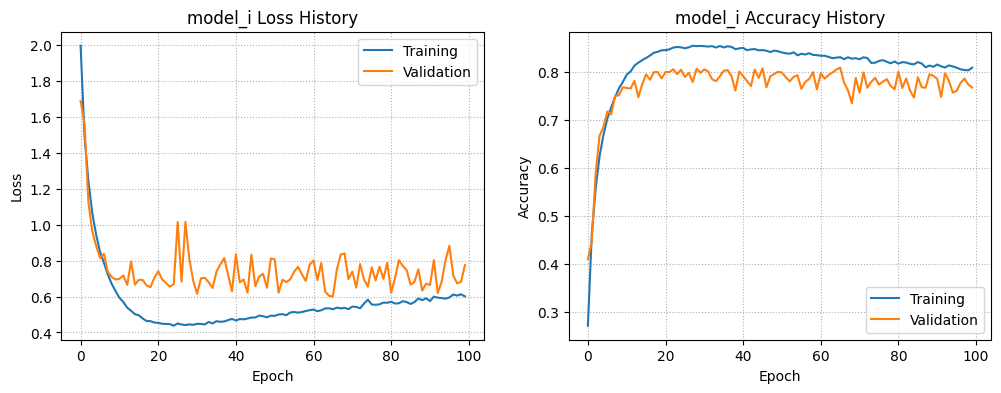

In [43]:
plot_history(history_i, 'model_i')

In [44]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_i)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_i)
lowest_loss = history_i.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_i', N_EPOCHS, BATCH_SIZE, 3, 32, model_i.count_params(),
                      0.25, 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 1s 5ms/step - loss: 0.8048 - accuracy: 0.7601
Test loss: 0.8047693967819214
Test accu: 0.7601000070571899
Min loss at epoch: 65
Max accu at epoch: 65


In [45]:
# model with dropout=0.5
model_ii = conv2d_with_reg(blocks=3, dropout=0.5)

model_ii.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [46]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_ii = model_ii.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 8s 20ms/step - loss: 2.0025 - accuracy: 0.2645 - val_loss: 1.7305 - val_accuracy: 0.3593
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 1.6208 - accuracy: 0.4089 - val_loss: 1.4536 - val_accuracy: 0.4672
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 1.4401 - accuracy: 0.4789 - val_loss: 1.2748 - val_accuracy: 0.5345
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 1.3176 - accuracy: 0.5278 - val_loss: 1.1462 - val_accuracy: 0.5822
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 1.2187 - accuracy: 0.5669 - val_loss: 1.1302 - val_accuracy: 0.5856
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 1.1434 - accuracy: 0.5941 - val_loss: 1.0240 - val_accuracy: 0.6351
Epoch 7/100
313/313 [==============================] - 6s 18ms/step - loss: 1.0831 - accuracy: 0.6167 - val_loss: 0.9502 - val_accuracy:

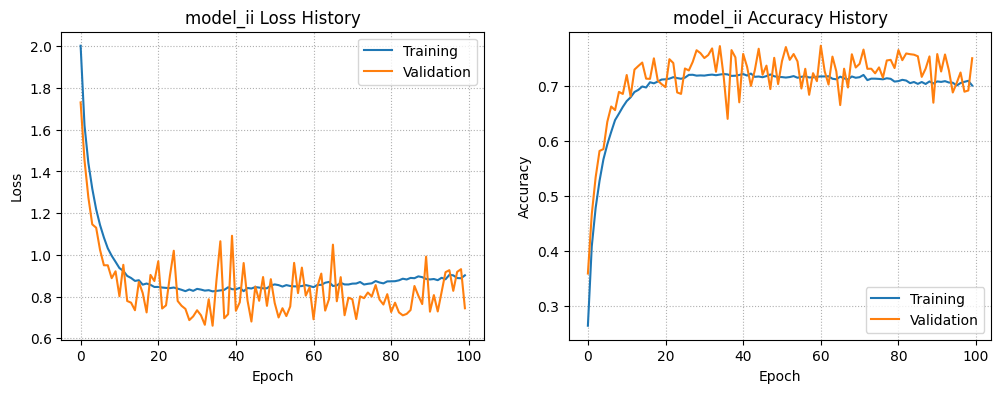

In [47]:
plot_history(history_ii, 'model_ii')

In [48]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_ii)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_ii)
lowest_loss = history_ii.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_ii', N_EPOCHS, BATCH_SIZE, 3, 32, model_ii.count_params(),
                      0.5, 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 1s 5ms/step - loss: 0.7492 - accuracy: 0.7508
Test loss: 0.7492139339447021
Test accu: 0.7508000135421753
Min loss at epoch: 34
Max accu at epoch: 60


In [49]:
# model with increasing dropout between sequential blocks from [0.25, 0.5]
model_iii = conv2d_with_reg(blocks=3, dropout=0.25, grad_dropout=True)

model_iii.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [50]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_iii = model_iii.fit(x_partial, y_partial,
                            validation_data=(x_val, y_val),
                            epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                            verbose=1)

Epoch 1/100
313/313 [==============================] - 7s 20ms/step - loss: 1.9954 - accuracy: 0.2718 - val_loss: 1.5601 - val_accuracy: 0.4302
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 1.5535 - accuracy: 0.4375 - val_loss: 1.3733 - val_accuracy: 0.5080
Epoch 3/100
313/313 [==============================] - 6s 19ms/step - loss: 1.3327 - accuracy: 0.5218 - val_loss: 1.2848 - val_accuracy: 0.5435
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 1.1821 - accuracy: 0.5790 - val_loss: 1.3116 - val_accuracy: 0.5441
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 1.0719 - accuracy: 0.6230 - val_loss: 0.9451 - val_accuracy: 0.6723
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.9933 - accuracy: 0.6500 - val_loss: 0.9187 - val_accuracy: 0.6780
Epoch 7/100
313/313 [==============================] - 6s 18ms/step - loss: 0.9352 - accuracy: 0.6747 - val_loss: 0.9632 - val_accuracy:

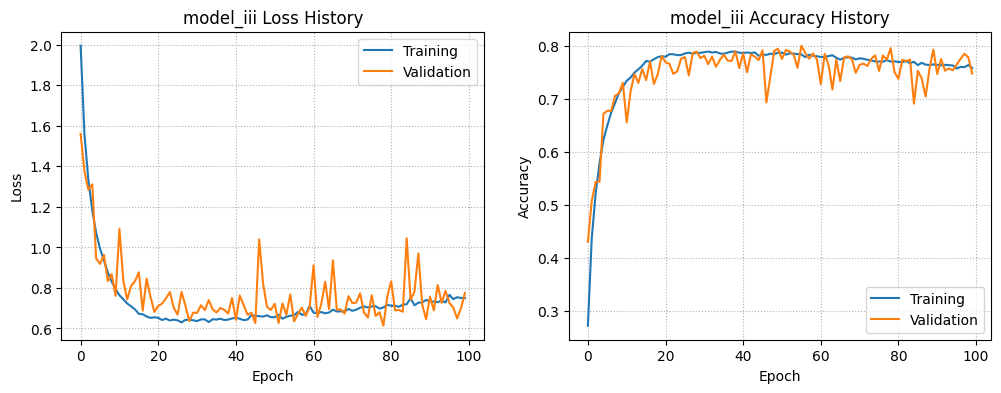

In [51]:
plot_history(history_iii, 'model_iii')

In [52]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_iii)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_iii)
lowest_loss = history_iii.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_iii', N_EPOCHS, BATCH_SIZE, 3, 32, model_iii.count_params(),
                      [0.25, 0.5], 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 2s 5ms/step - loss: 0.7910 - accuracy: 0.7399
Test loss: 0.791041374206543
Test accu: 0.7399000525474548
Min loss at epoch: 78
Max accu at epoch: 55


## 7.2 Comparison of Dropouts


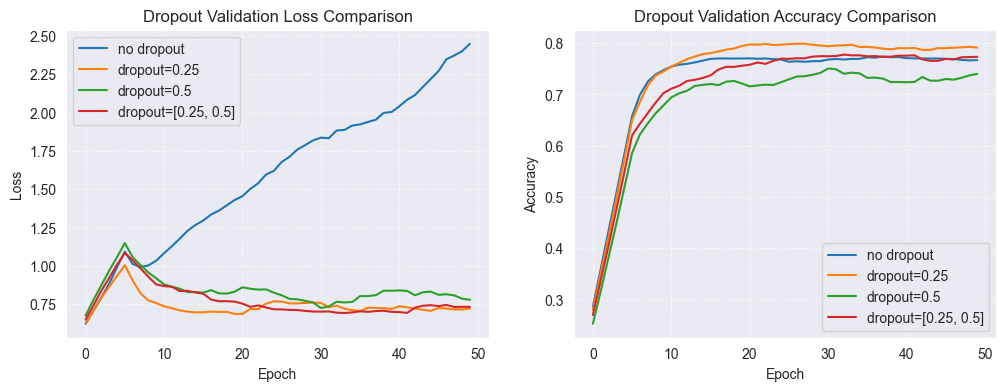

In [366]:
# plot histories of models with dropout
histories = [history_e, history_i, history_ii, history_iii]
params = ['no dropout', 'dropout=0.25', 'dropout=0.5', 'dropout=[0.25, 0.5]']

plot_history_comparison(histories=histories,
                        legend_names=params,
                        title='Dropout',
                        lim=50)

### Observations & Thoughts on Dropout

## 7.3 Optimizer Testing


In [54]:
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# model with adjusted RMSprop optimizer
model_or = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer=OPT)

model_or.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [55]:
N_EPOCHS = 200
BATCH_SIZE = 128


history_or = model_or.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 7s 20ms/step - loss: 2.0879 - accuracy: 0.2184 - val_loss: 1.8865 - val_accuracy: 0.3311
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 1.8271 - accuracy: 0.3276 - val_loss: 1.7053 - val_accuracy: 0.3749
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 1.7268 - accuracy: 0.3664 - val_loss: 1.6239 - val_accuracy: 0.4050
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 1.6568 - accuracy: 0.3916 - val_loss: 1.5427 - val_accuracy: 0.4373
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 1.5903 - accuracy: 0.4209 - val_loss: 1.4787 - val_accuracy: 0.4608
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 1.5288 - accuracy: 0.4430 - val_loss: 1.4109 - val_accuracy: 0.4859
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 1.4781 - accuracy: 0.4649 - val_loss: 1.4909 - val_accuracy:

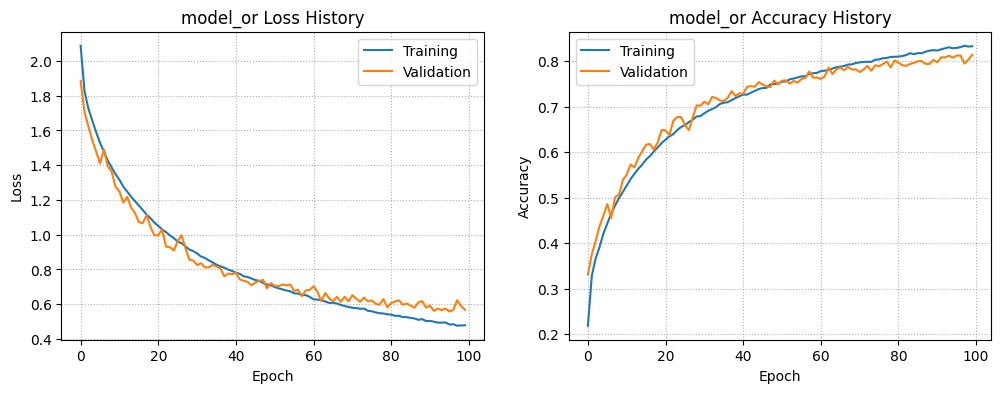

In [56]:
plot_history(history_or, 'model_or')

In [57]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_or)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_or)
lowest_loss = history_or.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_or', N_EPOCHS, BATCH_SIZE, 3, 32, model_or.count_params(),
                      [0.25, 0.5], 'rmsprop*', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 2s 5ms/step - loss: 0.5718 - accuracy: 0.8101
Test loss: 0.5717617273330688
Test accu: 0.8101000189781189
Min loss at epoch: 95
Max accu at epoch: 99


In [58]:
# model with optimizer='adam'
model_oa = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer='adam')

model_oa.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_48 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [59]:
N_EPOCHS = 200
BATCH_SIZE = 128


history_oa = model_oa.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 7s 19ms/step - loss: 1.8161 - accuracy: 0.3164 - val_loss: 1.4410 - val_accuracy: 0.4639
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 1.4178 - accuracy: 0.4793 - val_loss: 1.2255 - val_accuracy: 0.5579
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 1.2019 - accuracy: 0.5664 - val_loss: 1.0689 - val_accuracy: 0.6220
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 1.0692 - accuracy: 0.6181 - val_loss: 1.0278 - val_accuracy: 0.6286
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 0.9765 - accuracy: 0.6534 - val_loss: 0.8584 - val_accuracy: 0.6967
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 0.9033 - accuracy: 0.6818 - val_loss: 0.8134 - val_accuracy: 0.7154
Epoch 7/100
313/313 [==============================] - 6s 18ms/step - loss: 0.8458 - accuracy: 0.7050 - val_loss: 0.7513 - val_accuracy:

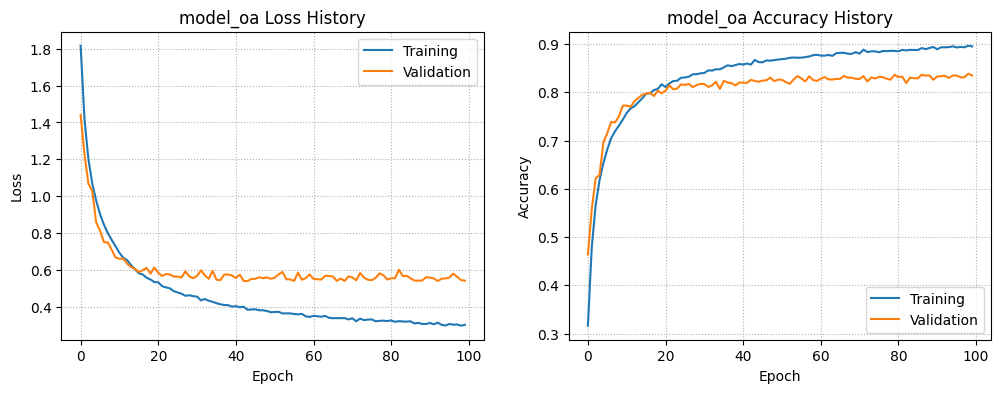

In [60]:
plot_history(history_oa, 'model_oa')

In [61]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_oa)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_oa)
lowest_loss = history_oa.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_oa', N_EPOCHS, BATCH_SIZE, 3, 32, model_oa.count_params(),
                      [0.25, 0.5], 'adam', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 2s 5ms/step - loss: 0.5798 - accuracy: 0.8263
Test loss: 0.5798413157463074
Test accu: 0.8263000249862671
Min loss at epoch: 92
Max accu at epoch: 98


In [62]:
# model with optimizer='adagrad'
model_og = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer='adagrad')

model_og.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_55 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [63]:
N_EPOCHS = 200
BATCH_SIZE = 128


history_og = model_og.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 7s 19ms/step - loss: 2.3032 - accuracy: 0.1009 - val_loss: 2.3002 - val_accuracy: 0.1096
Epoch 2/100
313/313 [==============================] - 5s 18ms/step - loss: 2.2999 - accuracy: 0.1096 - val_loss: 2.2978 - val_accuracy: 0.1209
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 2.2963 - accuracy: 0.1144 - val_loss: 2.2939 - val_accuracy: 0.1156
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 2.2908 - accuracy: 0.1203 - val_loss: 2.2856 - val_accuracy: 0.1333
Epoch 5/100
313/313 [==============================] - 5s 18ms/step - loss: 2.2769 - accuracy: 0.1267 - val_loss: 2.2637 - val_accuracy: 0.1419
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 2.2450 - accuracy: 0.1464 - val_loss: 2.2159 - val_accuracy: 0.1876
Epoch 7/100
313/313 [==============================] - 5s 18ms/step - loss: 2.1945 - accuracy: 0.1731 - val_loss: 2.1561 - val_accuracy:

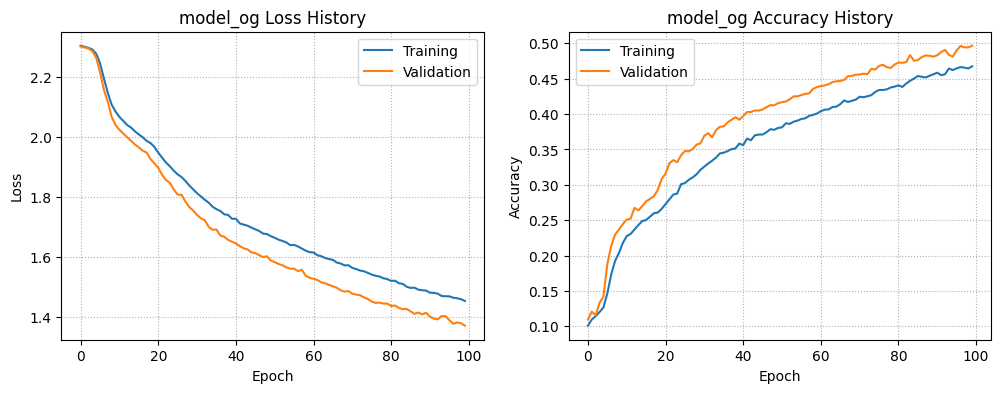

In [64]:
plot_history(history_og, 'model_og')

In [65]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_og)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_og)
lowest_loss = history_og.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_og', N_EPOCHS, BATCH_SIZE, 3, 32, model_og.count_params(),
                      [0.25, 0.5], 'adagrad', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 1s 5ms/step - loss: 1.3587 - accuracy: 0.5054
Test loss: 1.3586938381195068
Test accu: 0.5054000020027161
Min loss at epoch: 99
Max accu at epoch: 99


## 7.4 Comparison of Optimizers


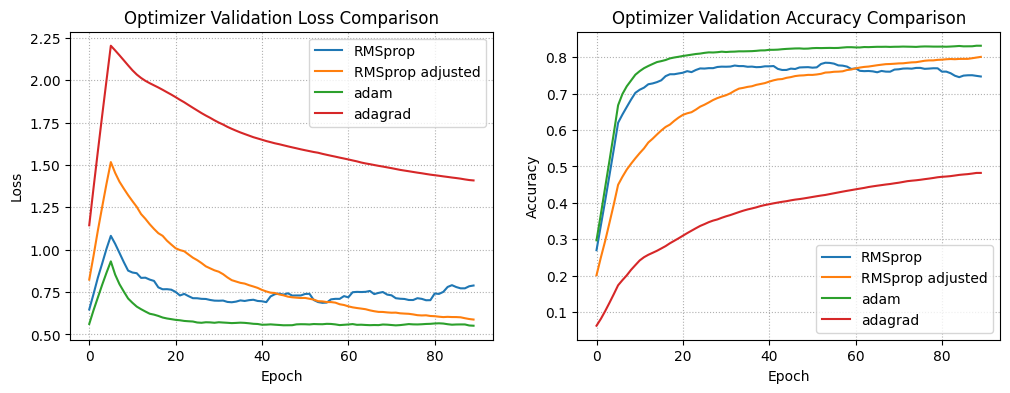

In [66]:
# plot histories of models with dropout
histories = [history_iii, history_or, history_oa, history_og]
params = ['RMSprop', 'RMSprop adjusted', 'adam', 'adagrad']

plot_history_comparison(histories=histories,
                        legend_names=params,
                        title='Optimizer',
                        lim=90)

### Observations & Thoughts on Optimizers

## 7.5 Regularizer Testing


In [67]:
REG = regularizers.l1(1e-4)
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# model with l1=0.0001 regularization
model_l1 = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer=OPT, regularizer=REG)

model_l1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_61 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [68]:
N_EPOCHS = 200
BATCH_SIZE = 128


history_l1 = model_l1.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 8s 20ms/step - loss: 3.9281 - accuracy: 0.1938 - val_loss: 3.5235 - val_accuracy: 0.2662
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 3.3174 - accuracy: 0.2878 - val_loss: 3.2518 - val_accuracy: 0.2719
Epoch 3/100
313/313 [==============================] - 6s 19ms/step - loss: 2.9951 - accuracy: 0.3474 - val_loss: 2.9161 - val_accuracy: 0.3532
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 2.8133 - accuracy: 0.3712 - val_loss: 2.6927 - val_accuracy: 0.4023
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 2.6639 - accuracy: 0.3933 - val_loss: 2.5449 - val_accuracy: 0.4163
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 2.5426 - accuracy: 0.4135 - val_loss: 2.4813 - val_accuracy: 0.4243
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 2.4458 - accuracy: 0.4244 - val_loss: 2.3699 - val_accuracy:

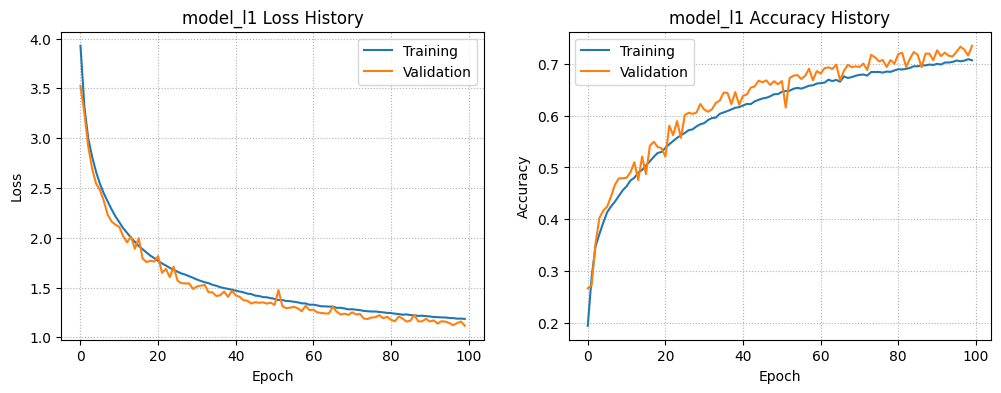

In [69]:
plot_history(history_l1, 'model_l1')

In [70]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_l1)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_l1)
lowest_loss = history_l1.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_l1', N_EPOCHS, BATCH_SIZE, 3, 32, model_l1.count_params(),
                      [0.25, 0.5], 'rmsprop*', 'l1=1e-4', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 2s 5ms/step - loss: 1.1093 - accuracy: 0.7354
Test loss: 1.1093153953552246
Test accu: 0.7354000210762024
Min loss at epoch: 99
Max accu at epoch: 99


In [71]:
REG = regularizers.l2(1e-4)
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# model with l2=0.0001 regularization
model_l2 = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer=OPT, regularizer=REG)

model_l2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_67 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [72]:
N_EPOCHS = 200
BATCH_SIZE = 128


history_l2 = model_l2.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 8s 20ms/step - loss: 2.1821 - accuracy: 0.2054 - val_loss: 1.9763 - val_accuracy: 0.3101
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 1.9251 - accuracy: 0.3159 - val_loss: 1.8940 - val_accuracy: 0.3379
Epoch 3/100
313/313 [==============================] - 6s 19ms/step - loss: 1.8084 - accuracy: 0.3611 - val_loss: 1.6937 - val_accuracy: 0.4109
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 1.7336 - accuracy: 0.3905 - val_loss: 1.6474 - val_accuracy: 0.4255
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 1.6666 - accuracy: 0.4182 - val_loss: 1.5592 - val_accuracy: 0.4567
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 1.6036 - accuracy: 0.4418 - val_loss: 1.4934 - val_accuracy: 0.4829
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 1.5479 - accuracy: 0.4613 - val_loss: 1.4535 - val_accuracy:

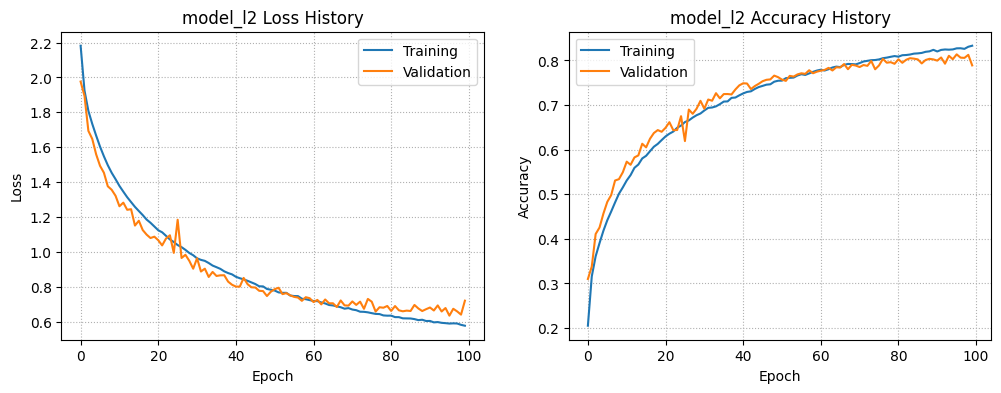

In [73]:
plot_history(history_l2, 'model_l2')

In [74]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_l2)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_l2)
lowest_loss = history_l2.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_l2', N_EPOCHS, BATCH_SIZE, 3, 32, model_l2.count_params(),
                      [0.25, 0.5], 'rmsprop*', 'l2=1e-4', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 2s 5ms/step - loss: 0.7292 - accuracy: 0.7914
Test loss: 0.7292312383651733
Test accu: 0.7914000153541565
Min loss at epoch: 95
Max accu at epoch: 95


In [75]:
REG = regularizers.l2(1e-3)
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# model with l2=0.001 regularization
model_l2a = conv2d_with_reg(blocks=3, dropout=0.25, grad_dropout=True,
                            optimizer=OPT, regularizer=REG)

model_l2a.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_72 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_73 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [76]:
N_EPOCHS = 200
BATCH_SIZE = 128


history_l2a = model_l2a.fit(x_partial, y_partial,
                            validation_data=(x_val, y_val),
                            epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                            verbose=1)

Epoch 1/100
313/313 [==============================] - 8s 20ms/step - loss: 2.7715 - accuracy: 0.1868 - val_loss: 2.4930 - val_accuracy: 0.2858
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 2.3617 - accuracy: 0.3129 - val_loss: 2.2241 - val_accuracy: 0.3625
Epoch 3/100
313/313 [==============================] - 6s 19ms/step - loss: 2.2001 - accuracy: 0.3562 - val_loss: 2.1702 - val_accuracy: 0.3643
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 2.0875 - accuracy: 0.3903 - val_loss: 1.9756 - val_accuracy: 0.4258
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 1.9957 - accuracy: 0.4144 - val_loss: 1.8795 - val_accuracy: 0.4490
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 1.9189 - accuracy: 0.4356 - val_loss: 1.8437 - val_accuracy: 0.4597
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 1.8511 - accuracy: 0.4582 - val_loss: 1.7523 - val_accuracy:

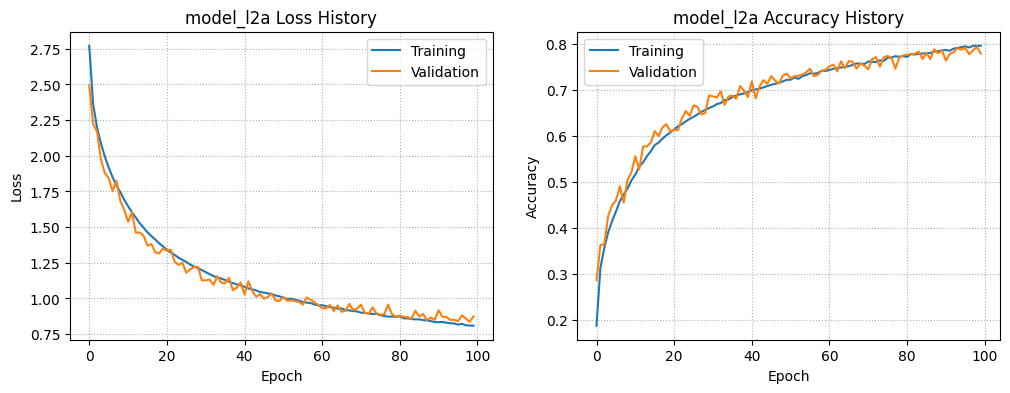

In [77]:
plot_history(history_l2a, 'model_l2a')

In [78]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_l2a)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_l2a)
lowest_loss = history_l2a.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_l2a', N_EPOCHS, BATCH_SIZE, 3, 32, model_l2a.count_params(),
                      [0.25, 0.5], 'rmsprop*', 'l2=1e-3', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 2s 5ms/step - loss: 0.8697 - accuracy: 0.7798
Test loss: 0.8697338104248047
Test accu: 0.7798000574111938
Min loss at epoch: 98
Max accu at epoch: 98


## 7.6 Comparison of Regularizers


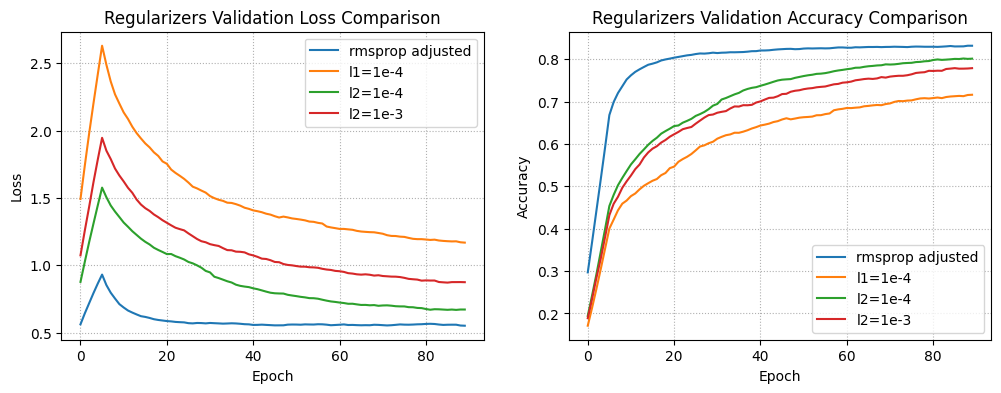

In [205]:
# plot histories of models with dropout
histories = [history_oa, history_l1, history_l2, history_l2a]
params = ['rmsprop adjusted', 'l1=1e-4', 'l2=1e-4', 'l2=1e-3']

plot_history_comparison(histories=histories,
                        legend_names=params,
                        title='Regularizers',
                        lim=90)

### Observations & Thoughts on Regularizers

# 8. Testing

Retrain best model on all training data Evaluate ONCE on test set


- `adam` and the adjusted `rmsprop` have similar loss and accuracy convergence
- the trade off being `adam` performs best without further regularization
- I will use rmsprop with the prospect it could potentially have lower loss with longer training


In [80]:
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# adjusted rmsprop model without regularizers
# change to model_s
model_s = conv2d_with_reg(blocks=3, dropout=0.25,
                          grad_dropout=True, optimizer=OPT)

model_s.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_77 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_78 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_79 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [81]:
N_EPOCHS = 250
BATCH_SIZE = 128


history_s = model_s.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/200
313/313 [==============================] - 8s 20ms/step - loss: 2.0784 - accuracy: 0.2191 - val_loss: 1.8432 - val_accuracy: 0.3481
Epoch 2/200
313/313 [==============================] - 6s 19ms/step - loss: 1.8262 - accuracy: 0.3246 - val_loss: 1.6872 - val_accuracy: 0.3900
Epoch 3/200
313/313 [==============================] - 6s 19ms/step - loss: 1.7149 - accuracy: 0.3690 - val_loss: 1.5999 - val_accuracy: 0.4090
Epoch 4/200
313/313 [==============================] - 6s 19ms/step - loss: 1.6301 - accuracy: 0.4012 - val_loss: 1.5435 - val_accuracy: 0.4263
Epoch 5/200
313/313 [==============================] - 6s 19ms/step - loss: 1.5614 - accuracy: 0.4263 - val_loss: 1.4510 - val_accuracy: 0.4700
Epoch 6/200
313/313 [==============================] - 6s 19ms/step - loss: 1.5018 - accuracy: 0.4522 - val_loss: 1.4468 - val_accuracy: 0.4680
Epoch 7/200
313/313 [==============================] - 6s 19ms/step - loss: 1.4473 - accuracy: 0.4783 - val_loss: 1.3267 - val_accuracy:

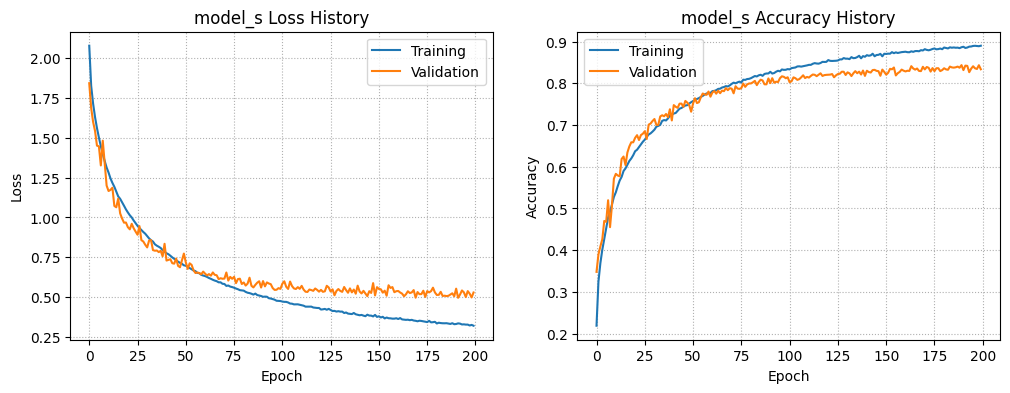

In [82]:
plot_history(history_s, 'model_s')

In [83]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_s)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_s)
lowest_loss = history_s.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_s', N_EPOCHS, BATCH_SIZE, 3, 32, model_s.count_params(),
                      [0.25, 0.5], 'rmsprop*', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 2s 5ms/step - loss: 0.5401 - accuracy: 0.8279
Test loss: 0.540144681930542
Test accu: 0.8279000520706177
Min loss at epoch: 191
Max accu at epoch: 189


## 8.1 Cohesive Testing Set Training


In [84]:
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

model_t = conv2d_with_reg(blocks=3, dropout=0.25,
                          grad_dropout=True, optimizer=OPT)

model_t.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_83 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_84 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_85 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [85]:
N_EPOCHS = loss_epoch
BATCH_SIZE = 128

X_train_t = prep_normalize(X_train)
y_train_t = prep_encoder(y_train)

history_t = model_t.fit(X_train_t, y_train_t,
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/191
391/391 [==============================] - 8s 17ms/step - loss: 2.0660 - accuracy: 0.2282
Epoch 2/191
391/391 [==============================] - 7s 18ms/step - loss: 1.7811 - accuracy: 0.3456
Epoch 3/191
391/391 [==============================] - 7s 17ms/step - loss: 1.6528 - accuracy: 0.3932
Epoch 4/191
391/391 [==============================] - 7s 17ms/step - loss: 1.5621 - accuracy: 0.4256
Epoch 5/191
391/391 [==============================] - 7s 17ms/step - loss: 1.4938 - accuracy: 0.4567
Epoch 6/191
391/391 [==============================] - 7s 18ms/step - loss: 1.4336 - accuracy: 0.4795
Epoch 7/191
391/391 [==============================] - 7s 17ms/step - loss: 1.3833 - accuracy: 0.4985
Epoch 8/191
391/391 [==============================] - 7s 17ms/step - loss: 1.3407 - accuracy: 0.5183
Epoch 9/191
391/391 [==============================] - 7s 17ms/step - loss: 1.2967 - accuracy: 0.5348
Epoch 10/191
391/391 [==============================] - 7s 17ms/step - loss: 1.258

In [86]:
loss_test, accu_test = evaluate_model(model_t)
# no val_loss to evaluate with final model

# save final model as .keras file
model_t.save('cifar10_CNN.keras')
# model = tf.keras.models.load_model('cifar10_CNN.keras')

# store results
model_summary.append(['model_t', N_EPOCHS, BATCH_SIZE, 3, 32, model_t.count_params(),
                      [0.25, 0.5], 'rmsprop*', '-', '-', loss_test, loss_test, accu_test])

313/313 [==============================] - 2s 5ms/step - loss: 0.5363 - accuracy: 0.8363
Test loss: 0.5363146066665649
Test accu: 0.8363000154495239


## 8.2 Evaluating the Final Model

Number of incorrect predictions: 1637/10000
Error rate: 0.1637
10 incorrect predictions, index=888


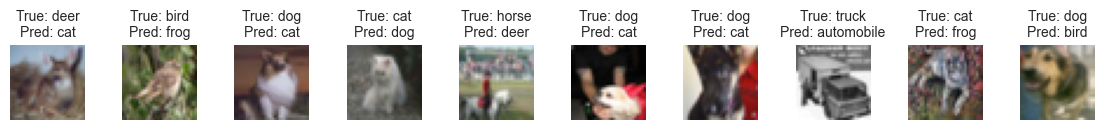

In [285]:
# use final trained model_t to predict testing data
y_pred = model_t.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

# get index count of false predictions
errors = np.sum(y_pred != y_test)
errors_index = np.where(y_pred != y_test)[0]
test_samples = len(y_pred)

print(f'Number of incorrect predictions: {errors}/{test_samples}')
print(f'Error rate: {errors/test_samples}')

# plot incorrect preditions, true vs predicted labels
low = np.random.randint(10, len(errors_index)-10)
high = low + 10

plot_multi_sample(X_test[errors_index][low:high],
                  y_test[errors_index][low:high].ravel(),
                  y_pred[errors_index][low:high],
                  name=f'incorrect predictions, index={low}')

10 correct predictions, index=2229


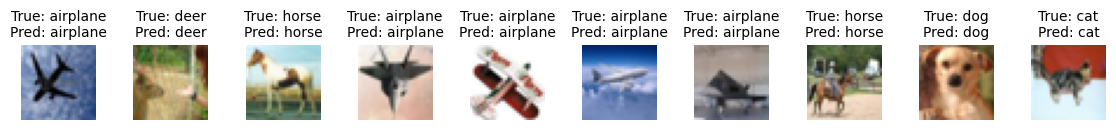

In [208]:
# plot correct preditions
correct_index = np.where(y_pred == y_test)[0]

# generate random index
low = np.random.randint(10, len(correct_index)-10)
high = low + 10

plot_multi_sample(X_test[correct_index][low:high],
                  y_test[correct_index][low:high].ravel(),
                  y_pred[correct_index][low:high],
                  name=f'correct predictions, index={low}')


total=1637


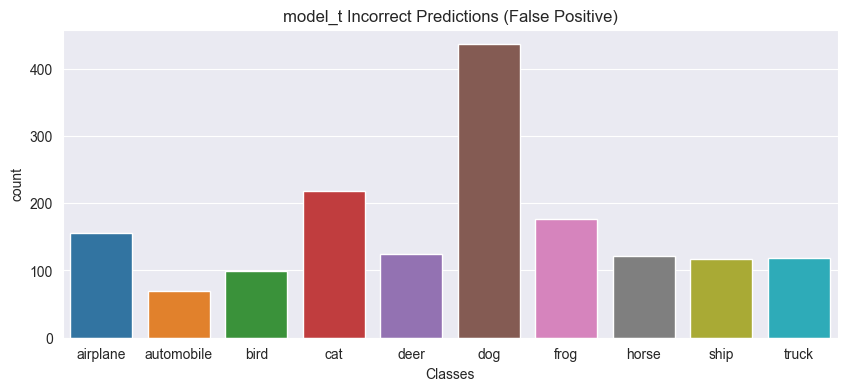

In [309]:
print(f'total={len(errors_index)}')

# plot errors
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x=y_pred[errors_index])
ax.set_xlabel('Classes')
classes = np.arange(0,10,1)
ax.set_xticklabels([target_names[name] for name in classes])
ax.set_title('model_t Incorrect Predictions (False Positive)')
plt.show()

total=8363


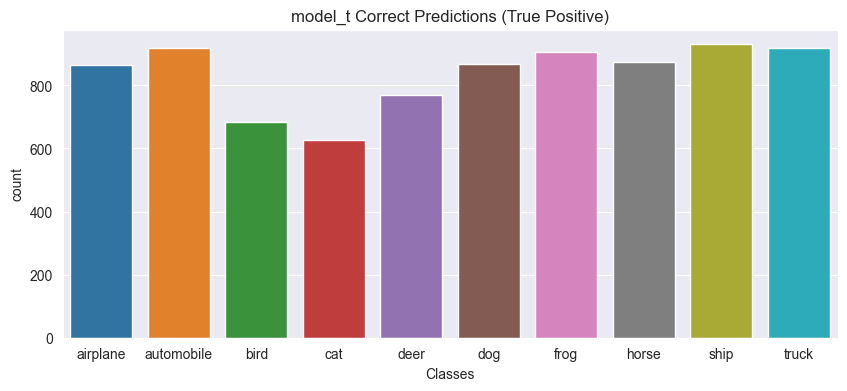

In [291]:
print(f'total={len(correct_index)}')

# plot errors
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x=y_pred[correct_index])
ax.set_xlabel('Classes')
ax.set_xticklabels(class_names)
ax.set_title('model_t Correct Predictions (True Positive)')
plt.show()


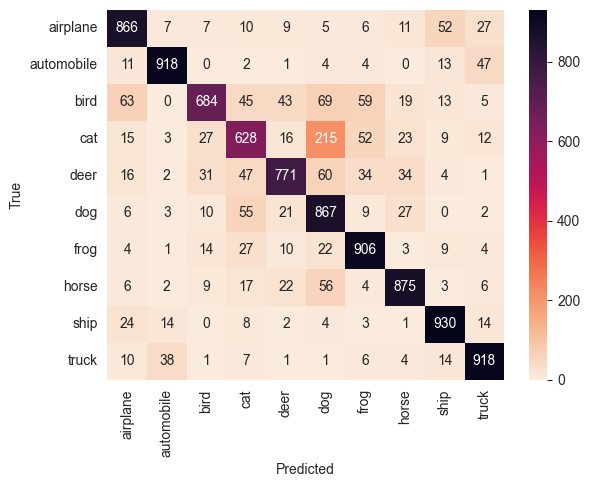

In [331]:
from sklearn.metrics import confusion_matrix, classification_report

data = confusion_matrix(y_test, y_pred)
# print(data)
ax = sns.heatmap(data, annot=True, fmt=".0f", cmap='rocket_r')
ax.set(xlabel="Predicted", ylabel="True")
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [357]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).round(2).transpose()

display(report_df)

,precision,recall,f1-score,support
0,0.85,0.87,0.86,1000.00
1,0.93,0.92,0.92,1000.00
2,0.87,0.68,0.77,1000.00
3,0.74,0.63,0.68,1000.00
4,0.86,0.77,0.81,1000.00
5,0.67,0.87,0.75,1000.00
6,0.84,0.91,0.87,1000.00
7,0.88,0.88,0.88,1000.00
8,0.89,0.93,0.91,1000.00
9,0.89,0.92,0.90,1000.00


# 9. Conclusion

In [359]:
# create dataframe
column_names = ['name', 'epochs', 'batch_size', 'blocks', 'layer_size', 'parameters',
                'dropout', 'optimizer', 'regularizer', 'fit epoch', 'lowest loss', 'test loss', 'test accu']

model_df = pd.DataFrame(model_summary, columns=column_names).round(2)
# model_df.set_index('name', inplace=True)

# export df as csv
model_df.to_csv('model_summary.csv', index=False)

display(model_df)
print('rmsprop* has learning_rate=1e-4, decay=1e-6')

,name,epochs,batch_size,blocks,layer_size,parameters,dropout,optimizer,regularizer,fit epoch,lowest loss,test loss,test accu
0,model,100,32,0,32,327818,-,rmsprop,-,5,1.54214,2.88,0.41
1,model_a,100,128,1,32,412266,-,rmsprop,-,5,1.026204,6.37,0.59
2,model_b,100,128,2,32,271786,-,rmsprop,-,11,0.856495,3.40,0.71
3,model_c,100,128,2,64,1082186,-,rmsprop,-,5,0.796781,4.44,0.74
4,model_d,100,128,3,32,814122,-,rmsprop,-,7,0.83576,3.75,0.74
5,model_e,100,128,3,64,3248202,-,rmsprop,-,6,0.844552,6.85,0.77
6,model_i,100,128,3,32,814122,0.25,rmsprop,-,65,0.600457,0.80,0.76
7,model_ii,100,128,3,32,814122,0.5,rmsprop,-,34,0.660459,0.75,0.75
8,model_iii,100,128,3,32,814122,"[0.25, 0.5]",rmsprop,-,78,0.61339,0.79,0.74
9,model_or,100,128,3,32,814122,"[0.25, 0.5]",rmsprop*,-,95,0.558191,0.57,0.81


rmsprop* has learning_rate=1e-4, decay=1e-6


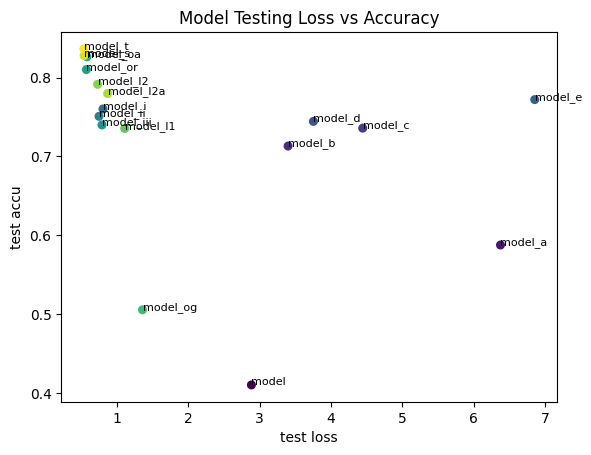

In [206]:
# split model_df by column
plot_df = model_df.loc[:, ['name', 'test loss', 'test accu']]
plot_df.set_index('name', inplace=True)

# adapted from [1] #answer-26000515
fig, ax = plt.subplots()
plot_df.plot(x='test loss', y='test accu', kind='scatter',
             ax=ax, s=30, c=range(len(plot_df)), title='Model Testing Loss vs Accuracy')

# plot and annotate points
for k, v in plot_df.iterrows():
    ax.annotate(k, v, xytext=(v[0], v[1]), fontsize=8)

## Ideas

- l2 regularization on every layer helps validation loss, regularizer=regularizers.l2(0.001) is too high, model is underfitting
- 0.3-0.5 dropout seems to be the sweet spot
- train final model on longer epochs
- 2 vs 3 blocks
- high dropout of 0.5 produces good accuracy and low loss, perhaps due to low quality of images (batch_size=128)


## Reflection

- process of finding optimal hyperparameters was most challenging
- hyperparameter tuning was similar to searching a stochastic space for optimal parameters
- observing small iterative changes with small training sizes is a tedious but good informed approach
- grid search of hyperparameters based on observations would have been a good approach

Not mentioned in notebook:

- batch_size increases reduced convergence rate, did not significantly increase or decrease loss and accu
- resources hhad a lot of conflicting ideas


# References

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

https://keras.io/api/layers/convolution_layers/convolution2d/

https://stackoverflow.com/questions/17888593/display-sequence-of-images-using-matplotlibmatpl

https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf alexnet

https://arxiv.org/pdf/1409.1556.pdf vgg16

https://cs231n.github.io/

https://web.eecs.umich.edu/~justincj/teaching/eecs498/FA2020/

https://matplotlib.org/stable/index.html

https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting-from-pandas-dataframe#answer-26000515

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

https://nchlis.github.io/2017_08_10/page.html

### Misc. GPU Testing


In [89]:
# native Windows tensorflow=2.10
!nvidia-smi


Thu Sep 14 05:31:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  | 00000000:01:00.0  On |                  N/A |
| 46%   59C    P0              48W / 172W |   7817MiB /  8192MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [90]:
# Look for GPU
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))


/device:GPU:0
Found GPU at: /device:GPU:0


In [91]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
